In [1]:
from matplotlib import pyplot as plt
import numpy as np
import fabio
from tkinter import filedialog
from tqdm.notebook import tqdm
import numpy as np
import math
import pyFAI.detectors
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from SPring8 import SP8_data
import os
from matplotlib.colors import ListedColormap, BoundaryNorm
import json
import os
import matplotlib.animation as animation
import matplotlib.cm as cm

plt.rcParams['figure.figsize'] = [5, 4]
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [ ]:
# 測定条件の設定
alpha = 2 # degree 入射角
twotheta = 12.2 # degree 2θ
wavelength = 0.1 # nm   X線波長
distance = 0.6161500 # nm   標準試料
pixelsize = 172 # um

In [21]:
# 画像の読み込み
path = filedialog.askopenfilename(title="Select Standard Sample", filetypes=[("tif files", "*.tif")])
# airの画像を読み込み
img_air = fabio.open(filedialog.askopenfilename(title="Select Air Picture", filetypes=[("tif files", "*.tif")])).data
# airを引いた画像を作成
img = fabio.open(path).data
img = img - img_air

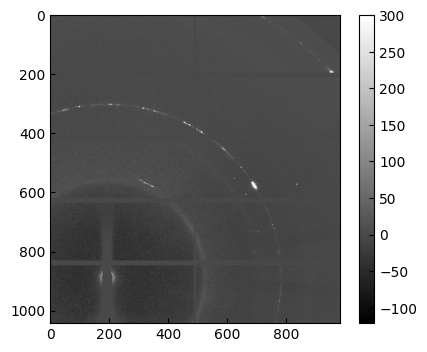

In [22]:
vmax = 300
plt.imshow(img, cmap='gray', vmax=vmax)
plt.colorbar()

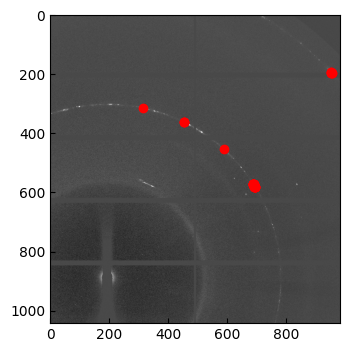

In [23]:
# 要操作
# 上位どれぐらいを二値化の範囲にするか選択
# xを境目に二値化
upper = 0.95
x = -(np.max(img)-np.min(img))*upper + np.max(img)
img_bin = np.where(img > x, 10, 0)
# plt.imshow(img_bin, cmap='gray')

# ピーク位置を特定
positions_org = []
for i in range(len(img_bin)):
    for j in range(len(img_bin[0])):
        if img_bin[i][j] == 10:
            plt.plot(j, i, 'ro')
            positions_org.append((j, i))
plt.imshow(img, cmap='gray', vmax=vmax)

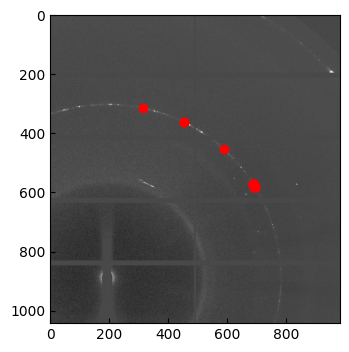

In [ ]:
from matplotlib.widgets import RectangleSelector

# 要操作
# 余分な点を削除（インタラクティブな矩形選択）

positions = []

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img, cmap='gray', vmax=vmax)
points_plot_init = ax.plot([x[0] for x in positions_org], [x[1] for x in positions_org], 'go', markersize=3)[0]
points_plot = ax.plot([x[0] for x in positions_org], [x[1] for x in positions_org], 'ro', markersize=3)[0]

selection_mode = {'add': True}  # True: 追加モード, False: 除外モード

def onselect(eclick, erelease):
    global positions
    x0 = min(eclick.xdata, erelease.xdata)
    x1 = max(eclick.xdata, erelease.xdata)
    y0 = min(eclick.ydata, erelease.ydata)
    y1 = max(eclick.ydata, erelease.ydata)
    
    # 選択範囲内の点を抽出
    selected = [p for p in positions_org if x0 <= p[0] <= x1 and y0 <= p[1] <= y1]
    
    if eclick.button == 1:  # 左クリック: 追加
        positions = list(set(positions + selected))
        print(f"追加: {len(selected)}点 (合計: {len(positions)}点)")
    elif eclick.button == 3:  # 右クリック: 除外
        positions = [p for p in positions if p not in selected]
        print(f"除外: {len(selected)}点 (残り: {len(positions)}点)")
    
    # プロット更新
    points_plot.set_data([x[0] for x in positions], [x[1] for x in positions])
    fig.canvas.draw_idle()

rect_selector = RectangleSelector(ax, onselect, useblit=True,
                                   button=[1, 3], minspanx=5, minspany=5,
                                   spancoords='pixels', interactive=True)

plt.title("左ドラッグ: 範囲追加 | 右ドラッグ: 範囲除外")
plt.show()

# 結果を確認
print(f"最終的な点数: {len(positions)}")

C:\Users\uttya\AppData\Local\Temp\ipykernel_22444\3855716772.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cxe=float(T[0]/-2)
C:\Users\uttya\AppData\Local\Temp\ipykernel_22444\3855716772.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cye=float(T[1]/-2)
C:\Users\uttya\AppData\Local\Temp\ipykernel_22444\3855716772.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  re=math.sqrt(cxe**2+cye**2-T[2])


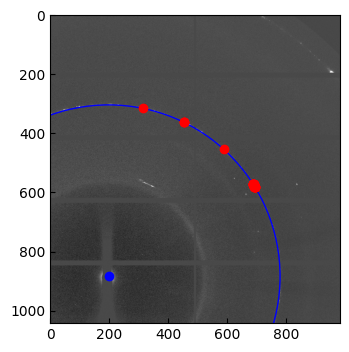

In [29]:
# 円のフィッティング関数
def CircleFitting(x,y):
    """最小二乗法による円フィッティングをする関数
        input: x,y 円フィッティングする点群

        output  cxe 中心x座標
                cye 中心y座標
                re  半径

        参考
        一般式による最小二乗法（円の最小二乗法）　画像処理ソリューション
        http://imagingsolution.blog107.fc2.com/blog-entry-16.html
    """

    sumx  = sum(x)
    sumy  = sum(y)
    sumx2 = sum([ix ** 2 for ix in x])
    sumy2 = sum([iy ** 2 for iy in y])
    sumxy = sum([ix * iy for (ix,iy) in zip(x,y)])

    F = np.array([[sumx2,sumxy,sumx],
                  [sumxy,sumy2,sumy],
                  [sumx,sumy,len(x)]])

    G = np.array([[-sum([ix ** 3 + ix*iy **2 for (ix,iy) in zip(x,y)])],
                  [-sum([ix ** 2 *iy + iy **3 for (ix,iy) in zip(x,y)])],
                  [-sum([ix ** 2 + iy **2 for (ix,iy) in zip(x,y)])]])

    T=np.linalg.inv(F).dot(G)

    cxe=float(T[0]/-2)
    cye=float(T[1]/-2)
    re=math.sqrt(cxe**2+cye**2-T[2])
    #print (cxe,cye,re)
    return (cxe,cye,re)

# 円フィッティング
x = [x[0] for x in positions]
y = [x[1] for x in positions]
cxe, cye, re = CircleFitting(x, y)
# print(cxe, cye, re)

# 結果の表示
plt.imshow(img, cmap='gray', vmax=vmax)
plt.plot([x[0] for x in positions], [x[1] for x in positions], 'ro')
plt.plot(cxe, cye, 'bo')
circle = plt.Circle((cxe, cye), re, color='b', fill=False)
plt.gca().add_artist(circle)
plt.show()

In [ ]:
# カメラ長算出のための係数
theta = math.asin(wavelength/(2*distance)) # rad
theta = math.degrees(theta) # degree

# camera lengthの計算
radius = re
camera_length = radius * pixelsize / math.tan(math.radians(2*theta)) * 1e-6 # m 
print(camera_length)

0.3180941709571633


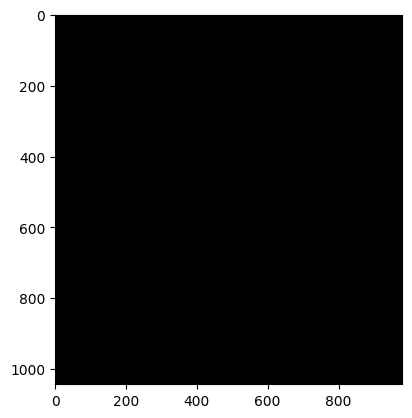

In [11]:
# マスクの作成
mask = np.zeros_like(img)
mask[img_air < 0] = 1
plt.imshow(mask, cmap='gray')

In [12]:
# detectorの作成
pixel_size = 172e-6 # um -> m
detector = pyFAI.detectors.Detector(pixel1=pixel_size, pixel2=pixel_size)
camera_length = camera_length # m
wavelength = 1e-10 # A -> m
# calibの作成
ai = AzimuthalIntegrator(dist=camera_length, detector=detector, wavelength=wavelength)
beam_center = (cxe, cye)
ai.setFit2D(camera_length*1000, *beam_center)

Detector Detector	 Spline= None	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.000000e-10 m
SampleDetDist= 5.517380e-01 m	PONI= 1.561512e-01, 3.755486e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 551.738 mm	Center: x=218.342, y=907.856 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.000Å

In [ ]:
# 解析データのパスを取得
file = filedialog.askdirectory(title="Select Data Directory")
files = os.listdir(file)
files = [os.path.join(file, f) for f in files if not f.endswith('.tif')]
paths = []
for file in files:
    _paths = os.listdir(file)
    _paths = [os.path.join(file, f) for f in _paths if f.endswith('.tif')]
    paths += _paths

# paths = files

# 画像の読み込み
img_data = fabio.open(paths[0]).data
img_data = img_data - img_air
img_data = img_data - img_data.min() + 1
img_data[mask == 1] = 0

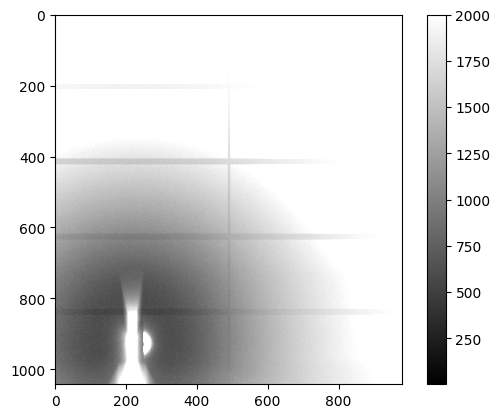

In [23]:
# 要操作
revmax = 2000
plt.imshow(img_data, cmap='gray', vmax=revmax)
plt.colorbar()

In [2]:
# ψ角の導出
def get_psi_angle(theta, alpha, delta):
    # degreeをradに変換
    theta = np.radians(theta)
    alpha = np.radians(alpha)
    delta = np.radians(delta)

    sin_phi = math.sqrt(1 - (np.cos(delta) * np.cos(theta))**2)
    cos_psi = np.sin(theta) * np.sin(alpha) + sin_phi * np.cos(theta) * np.cos(alpha)
    psi = math.acos(cos_psi)
    return math.degrees(psi)

delta: 90 -> psi: 10.2
delta: 80 -> psi: 14.06
delta: 70 -> psi: 21.88
delta: 60 -> psi: 30.73
delta: 50 -> psi: 39.88
delta: 40 -> psi: 49.09
delta: 30 -> psi: 58.17
delta: 20 -> psi: 66.82
delta: 10 -> psi: 74.21


Text(0, 0.5, '$\\sin^2\\psi$')

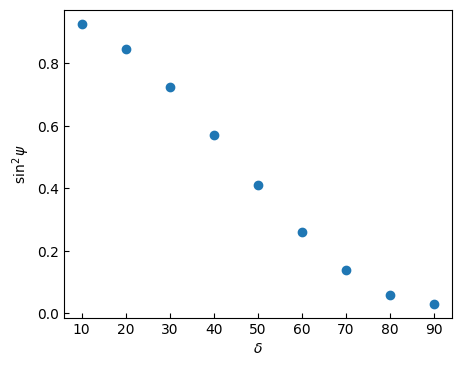

In [4]:
# 要操作
# ψ角の確認
deltas = [90, 80, 70, 60, 50, 40, 30, 20, 10]
alpha = 2
theta = 12.2
psis = [get_psi_angle(theta, alpha, delta) for delta in deltas]
for delta, psi in zip(deltas, psis):
    print(f"delta: {delta} -> psi: {round(psi, 2)}")
plt.plot(deltas, (np.sin(np.radians(psis))) ** 2, 'o')
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\sin^2\psi$')

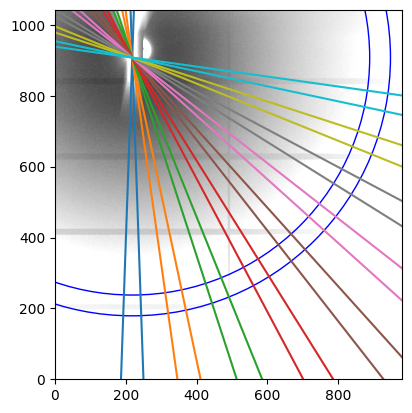

In [ ]:
# 要操作
# 条件の読み込み
radial_init = 11.8
radial_final = 12.8

colors = plt.get_cmap('tab10')(np.linspace(0, 1, len(deltas)))

# プロット
for i, delta in enumerate(deltas):
    plt.imshow(img_data, cmap='gray', vmax=revmax)
    x_vals = np.array([0, img_data.shape[1]])
    y_vals = cye + np.tan(np.radians(-delta + 2)) * (x_vals - cxe)
    plt.plot(x_vals, y_vals, '-', color = colors[i])
    y_vals = cye + np.tan(np.radians(-delta - 2)) * (x_vals - cxe)
    plt.plot(x_vals, y_vals, '-', color = colors[i])

# 中心位置からの距離を計算
def calculate_distance_from_center(camera_length, two_theta, pixel_size):
    return camera_length * np.tan(np.radians(two_theta)) / pixel_size

inner = calculate_distance_from_center(camera_length, radial_init, pixel_size)
outer = calculate_distance_from_center(camera_length, radial_final, pixel_size)
circle_inner = plt.Circle((cxe, cye), inner, color='b', fill=False)
circle_outer = plt.Circle((cxe, cye), outer, color='b', fill=False)
plt.gca().add_artist(circle_inner)
plt.gca().add_artist(circle_outer)
    
xlim = img_data.shape[1]
ylim = img_data.shape[0]
plt.xlim(0, xlim)
plt.ylim(0, ylim)
plt.show()

In [29]:
def logging(log):
    return

In [34]:
def alpha_phi_psi(path, alpha, phis):
    no = int(path.split('/')[-1].split('.')[0].split('_')[-4])
    no = no / 100
    theta = 12.2
    psis = [get_psi_angle(theta, alpha, phi) for phi in phis]
    return psis

In [32]:
paths = [path for path in paths if 'merge' in path]

In [ ]:
# データ解析
datas = []
for path in tqdm(paths):
    path = path.replace("\\", "/")
    try:
        img = fabio.open(path).data
        data = SP8_data()
        # airを引く
        img -= img_air
        # integrate
        for i, phi in enumerate(phis):            
            res = ai.integrate1d(img, 1300, 
                                    unit="2th_deg",
                                    radial_range=(radial_init,radial_final),
                                    azimuth_range=(-phi-2,-phi+2),
                                    mask=mask
                            )
            psis = alpha_phi_psi(path, alpha, phis)
            data.append(res.radial, res.intensity, psis[i], logging=logging)

        data.set_status({"poisson": 0.4, "modulus": 5.9, "wavelength_SPring8": 0.1}, logging=logging)
        data.fitting(logging=logging)

        # ファイルの名前を分析
        file_name = path.split("/")[-1].replace(".tif","")
        samp = path.split("/")[-2]
        data.save_datas(f"datas/SPring8/{samp}", file_name, logging=logging)

        datas.append(data)

    except Exception as e:
        print(e, path)

  0%|          | 0/270 [00:00<?, ?it/s]

invalid literal for int() with base 10: 'air' //nishinolab-data/Public/SPring-8/20240420_BL05XU/WAXD_124keV_05m01nm/air_1s_1_merge.tif
invalid literal for int() with base 10: 'WS2' //nishinolab-data/Public/SPring-8/20240420_BL05XU/WAXD_124keV_05m01nm/WS2_1s_1_merge.tif


In [ ]:
# ここまで

In [ ]:
%matplotlib inline

In [ ]:
import json
with open("datas/Et/20250419/analyses/save_data.json", "r") as f:
    data = json.load(f)

a, b = data["slope temp vs Et"], data["intercept temp vs Et"]

In [ ]:
Et_temp = np.arange(40, 251, 2.5)
Et = a * Et_temp + 5.9
Et[Et_temp > 170] = 1
plt.plot(Et_temp, Et, label="Et vs temp", color="red")

  0%|          | 0/6 [00:00<?, ?it/s]

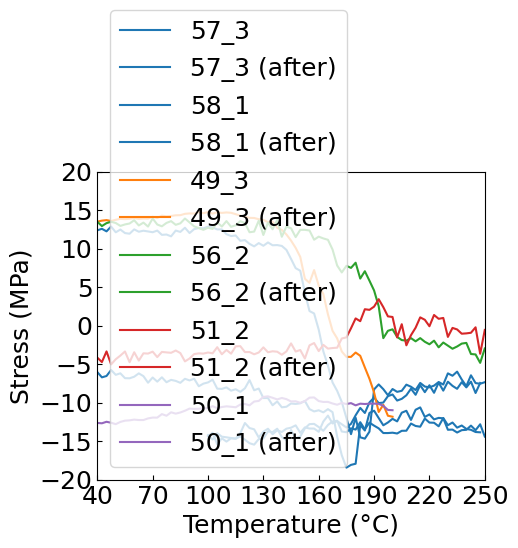

In [49]:
path_all = ['57_3', '58_1', '49_3', '56_2', '51_2', "50_1"]
colors = plt.get_cmap('tab10')(np.linspace(0, 1, len(path_all)*2))

fig = plt.figure(figsize=(5,4))

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 18
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'


for j, pp in enumerate(tqdm(path_all)):
    paths = os.listdir(f"datas/SPring8/{pp}")
    paths = [p for p in paths if 'before' not in p]
    paths = [p for p in paths if 'test' not in p]
    stresses = []
    temps = []
    stds = []
    for p in paths:
        path = f"datas/SPring8/{pp}/{p}"
        data = SP8_data(path=path)
        i = int(p.split("_")[-1])
        if i < 85:
            temp = i * 2.5 + 40
        else:
            temp = 250 - (i - 84) * 2.5
        stress = data.r
        std =data.ci_r

        # stress = stress / 5.9 * Et[Et_temp == temp][0]

        stresses.append(stress)
        temps.append(temp)
        stds.append(std)
        if stress > 100:
            print(f"Stress: {stress} GPa, path: {path}")
    plt.plot(temps[:85], stresses[:85], color=colors[j], label=pp)
    plt.plot(temps[85:], stresses[85:], color=colors[j], label=pp+" (after)")

plt.xlabel('Temperature (°C)')
plt.ylabel('Stress (MPa)')
# plt.twinx()
# plt.plot(temp_tma, exp, 'k--', label='TMA')
# plt.ylabel('Expansion (%)')
plt.xlim(40, 250)
plt.xticks(np.arange(40, 251, 30))
plt.ylim(-15, 15)
plt.yticks(np.arange(-20, 21, 5))

plt.legend()
plt.savefig(filedialog.asksaveasfile(title="Save Figure", defaultextension=".svg", filetypes=[("SVG files", "*.svg")]).name, bbox_inches='tight')

  0%|          | 0/3 [00:00<?, ?it/s]

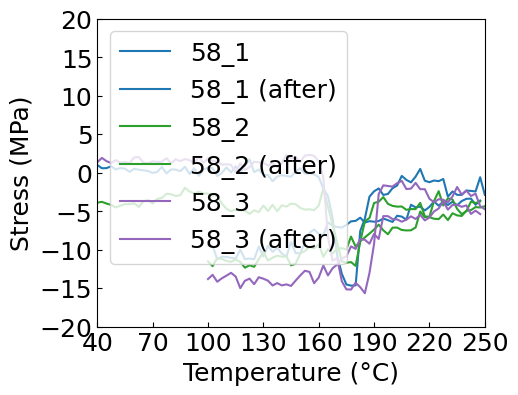

In [29]:
path_all = ['58_1', '58_2', '58_3']
colors = plt.get_cmap('tab10')(np.linspace(0, 1, len(path_all)*2))

fig = plt.figure(figsize=(5,4))

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 18
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'


for j, pp in enumerate(tqdm(path_all)):
    paths = os.listdir(f"datas/SPring8/{pp}")
    paths = [p for p in paths if 'before' not in p]
    paths = [p for p in paths if 'test' not in p]
    stresses = []
    temps = []
    stds = []
    for p in paths:
        path = f"datas/SPring8/{pp}/{p}"
        data = SP8_data(path=path)
        i = int(p.split("_")[-1])
        if i < 85:
            temp = i * 2.5 + 40
        else:
            temp = 250 - (i - 84) * 2.5
        stress = data.r
        std =data.ci_r

        # stress = stress / 5.9 * Et[Et_temp == temp][0]

        stresses.append(stress)
        temps.append(temp)
        stds.append(std)
        if stress > 100:
            print(f"Stress: {stress} GPa, path: {path}")
    plt.plot(temps[:85], stresses[:85], color=colors[j], label=pp)
    plt.plot(temps[85:], stresses[85:], color=colors[j], label=pp+" (after)")

plt.xlabel('Temperature (°C)')
plt.ylabel('Stress (MPa)')
# plt.twinx()
# plt.plot(temp_tma, exp, 'k--', label='TMA')
# plt.ylabel('Expansion (%)')
plt.xlim(40, 250)
plt.xticks(np.arange(40, 251, 30))
plt.ylim(-15, 15)
plt.yticks(np.arange(-20, 21, 5))

plt.legend()
# plt.savefig(filedialog.asksaveasfile(title="Save Figure", defaultextension=".svg", filetypes=[("SVG files", "*.svg")]).name, bbox_inches='tight')

In [ ]:
data = SP8_data(path="datas/SPring8/59_1/59_1_EPPEEK_none_insitu_200_1s_00074")
data.plot_fitting()

In [33]:
import matplotlib.animation as animation

In [ ]:
%matplotlib tk
dirname = "datas/SPring8/58_1"
paths = os.listdir(dirname)
paths = [p for p in paths if 'before' not in p]
paths = [p for p in paths if 'test' not in p]
paths = [os.path.join(dirname, p) for p in paths]
paths = sorted(paths, key=lambda x: int(x.split("_")[-1].split(".")[0]))

def animate(path):
    ax.cla()
    data = SP8_data(path=path)
    data.plot_fitting(save_path=None, logging=logging, ax=ax)
    plt.text(0.5, 1.05, f"Frame: {os.path.basename(path)}", 
                     horizontalalignment='center', verticalalignment='center', 
                     transform=plt.gca().transAxes, fontsize=12)

fig, ax = plt.subplots(figsize=(10, 10))

ani = animation.FuncAnimation(fig, animate, frames=paths, interval=300, repeat=True)
ani.save(filedialog.asksaveasfile(title="Save Animation", defaultextension=".gif", filetypes=[("GIF files", "*.gif")]).name, writer='pillow', fps=10)

[0.0011454263959003175, 0.0006464311692546687, 0.00018231816570479786, -0.0002063614186300633, -0.0010317712610056207, -0.0013100544761982524, -0.0015139227516274278, -0.002233600537071556]
[0.0008409005801552905, 0.0002625522755719256, -0.0001552844402176179, -0.0004624444582220777, -0.0004454155522084502, -0.00038932234051503034, -0.0002977500889876916, 0.001567804131161754, 0.00432204139345993]
[0.00047066523775862734, 0.00018530371975433724, 3.89331766346146e-05, 7.917506180898926e-06, -0.000533260387724277, -0.0006413231779858197, -0.0002767112923791615, 0.0004850842363115504]


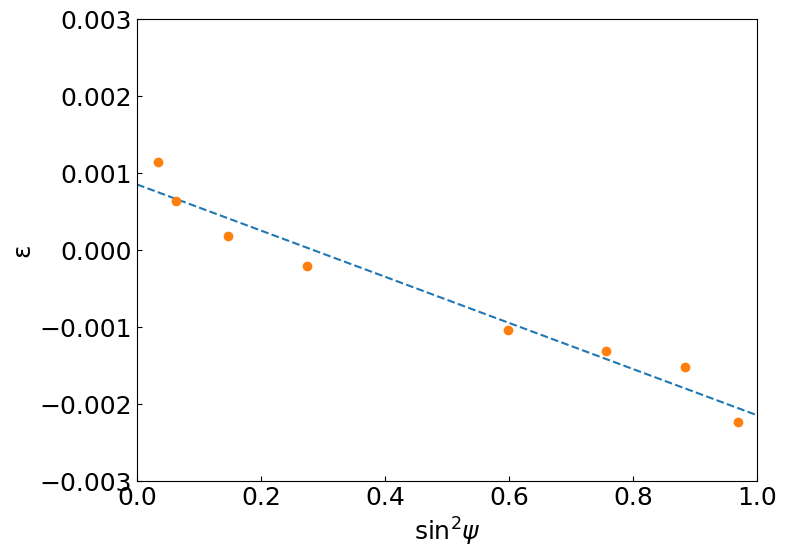

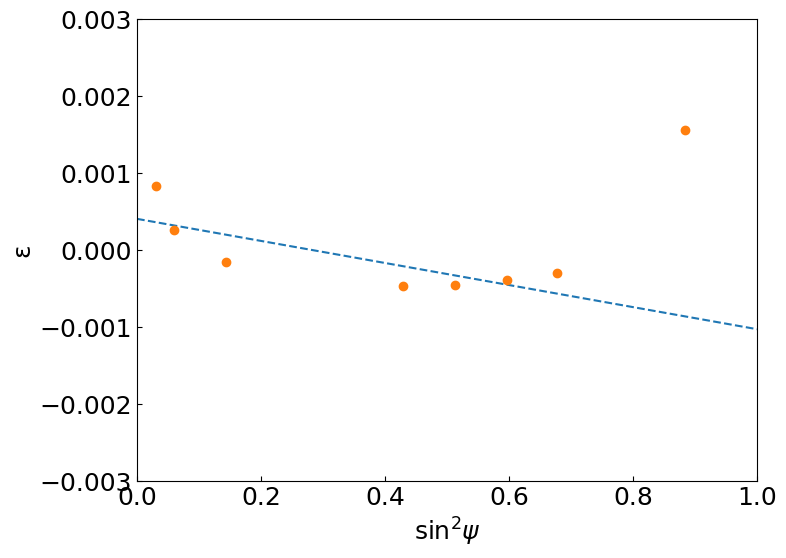

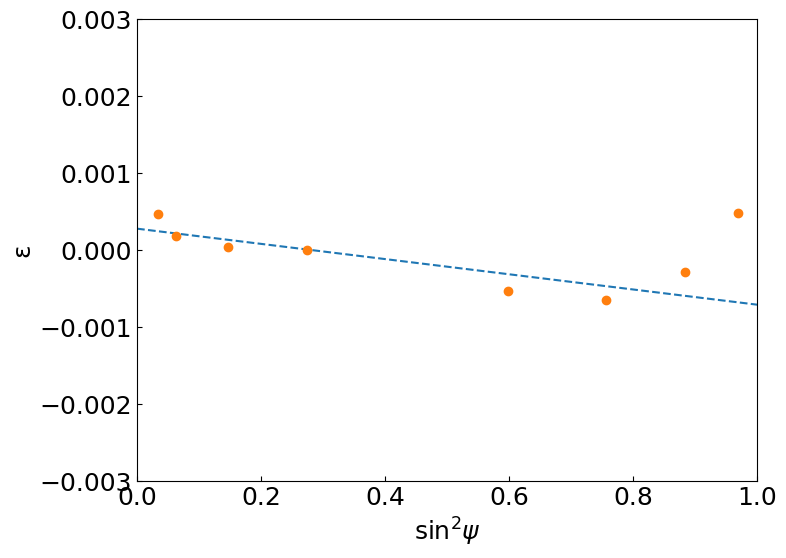

In [47]:
all = ['50_1', '58_1', '51_2']
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 18
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.figsize'] = (5, 4)
for i, pp in enumerate(all):
    paths = os.listdir(f"datas/SPring8/{pp}")
    paths = [p for p in paths if 'before' not in p]
    paths = [p for p in paths if 'test' not in p]
    paths = [os.path.join(f"datas/SPring8/{pp}", p) for p in paths]
    paths = sorted(paths, key=lambda x: int(x.split("_")[-1].split(".")[0]))
    data = SP8_data(path=paths[0])
    data.plot_e()
    print(data.e)

In [46]:
all = ['58_1', '58_2', '58_3']
for i, pp in enumerate(tqdm(all)):
    paths = os.listdir(f"datas/SPring8/{pp}")
    paths = [p for p in paths if 'before' not in p]
    paths = [p for p in paths if 'test' not in p]
    paths = [os.path.join(f"datas/SPring8/{pp}", p) for p in paths]
    paths = sorted(paths, key=lambda x: int(x.split("_")[-1].split(".")[0]))
    for j, path in enumerate(tqdm(paths)):
        data = SP8_data(path=path)
        data.bools[-2] = False
        data.recalc_stress(data.bools)
        data.save_datas(path.split("\\")[0], path.split("\\")[-1])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データ

  0%|          | 0/145 [00:00<?, ?it/s]

応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データ

  0%|          | 0/145 [00:00<?, ?it/s]

応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データを保存しました
応力の計算が完了しました
データ

In [ ]:
paths = os.listdir("datas/SPring8/57_2")
datas = []
for i, p in enumerate(paths):
    path = f"datas/SPring8/57_2/{p}"
    data = SP8_data(path=path)
    datas.append(data)

In [ ]:
import pandas as pd
# excelファイルの読み込み
df = pd.read_excel(path, sheet_name="Sheet2", header=None, index_col=None)

indices = df.loc[df.iloc[:, 1] == "Time(min)"].index.tolist()[0]

data = df[indices + 1 :]
data.columns = df.iloc[indices]
data = data[["Time(min)", "Temp.(℃)", "TMA(μm)"]]


temps = [[1000]]
TMAs = [[]]
_temp = 0

for d in data.itertuples():
    temp = d[2]
    tma = d[3]
    if _temp <= temp:
        if temp <= temps[-1][-1]:
            temps.append([])
            TMAs.append([])
        temps[-1].append(temp)
        TMAs[-1].append(tma)
    _temp = temp

temps = [temp for temp in temps if len(temp) >= 100]
TMAs = [tma for tma in TMAs if len(tma) >= 100]


for _temp, _tma in zip(temps, TMAs):
    # tempが30~200℃の範囲にあるデータのみを抽出
    temp = []
    tma = []
    for i, t in enumerate(_temp):
        if 30 <= t <= 200:
            temp.append(t)
            tma.append(_tma[i])

    L0 = 20000 + tma[0]
    exp = [(L + 20000 - L0) / L0 * 100 for L in tma]

    plt.plot(temp, exp)
    plt.legend(range(len(temps)))
# pltの設定
plt.xlabel("Temperature(°C)")
plt.ylabel("expansion(%)")
plt.xlim(40, 200)
plt.ylim(0, 1.5)
plt.tight_layout()

In [ ]:
import json
parent_path = "datas/SPring8/56_1"
paths = os.listdir(parent_path)
for path in paths:
    with open(f"{parent_path}/{path}/.json", 'r') as file:
        data = json.load(file)

    data = json.dumps(data).replace('59_', '56_')
    data = json.loads(data)

    with open(f"{parent_path}/{path}/.json", 'w') as file:
        json.dump(data, file, indent=4)

In [ ]:
tma_temp = temps[0]
tma_exp = TMAs[0]

In [ ]:
plt.plot(temp, exp)
temp_l = [t for t in temp if 50 < t < 120]
exp_l = [exp[i] for i, t in enumerate(temp) if 50 < t < 120]
a1, b1 = np.polyfit(temp_l, exp_l, 1)
plt.plot(temp, [a1 * t + b1 for t in temp])
temp_h = [t for t in temp if 160 < t < 180]
exp_h = [exp[i] for i, t in enumerate(temp) if 160 < t < 180]
a2, b2 = np.polyfit(temp_h, exp_h, 1)
plt.plot(temp, [a2 * t + b2 for t in temp])
plt.ylim(0, 1.3)
# 交点の計算
intersection_x = (b2 - b1) / (a1 - a2)
intersection_y = a1 * intersection_x + b1

# 交点のプロット
plt.plot(intersection_x, intersection_y, 'go')
plt.show()

print(f"Intersection point: ({intersection_x}, {intersection_y})")

In [ ]:
dirname = "datas/SPring8/49_3"
paths = os.listdir(dirname)
paths = [p for p in paths if 'before' not in p]
paths = [p for p in paths if 'test' not in p]
paths.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
paths = [os.path.join(dirname, p) for p in paths]
d_spacing = []
for path in paths:
    data = SP8_data(path=path)
    d_spacing.append(data.d0)

temp = [40 + int(path.split("_")[-1]) * 2.5 for path in paths]
plt.plot(temp, d_spacing)

In [37]:
datas = [SP8_data(path=os.path.join('datas/SPring8/WAXD_124keV_05m01nm', path)) for path in os.listdir("datas/SPring8/WAXD_124keV_05m01nm")]
for data in datas:
    print(data.r)

-6.065836204093215
-9.358518113375105
-11.11835533508679
-11.358636341895997
-7.394162166648499
-0.22540419278886123
5.391325333554467
4.677626639369884
7.5284352501575205
-3.348858725626428
-6.6504471167190715
-9.474512200761255
-10.614113407027848
-7.389274622025636
-2.7117198062206582
0.7629444888294795
3.0535800783478293
7.444882083978882
-9.634715524001267
-9.313869785169167
-12.662452255354426
-13.312161067634223
-7.603263562175058
-1.7633897521567303
3.542600786713902
5.3064679834811725
5.330057531850382
10.449084201377666
-9.258605198503538
-9.457620214340345
-7.31596765758878
-3.9389017986133594
-0.8877453201280482
1.1474409924502205
1.5616684537254635
3.8627239154963595
9.552054039617447
-9.840632725899416
-11.409008404299822
-10.350478320884246
-5.608161102445195
-1.0591455347997734
0.7829716529303543
0.45056317702750137
0.6459189748261269
7.290518406829038
-9.135678058099888
-12.623583753233346
-14.997188948280622
-16.817468850294603
-13.960791841411444
-6.996510278891408
2

In [3]:
import depth

波長: 1e-10 m
エネルギー: 12.42 keV
μ(H): 0.39 cm^2/g
μ(C): 1.40 cm^2/g
μ(N): 2.21 cm^2/g
μ(O): 3.31 cm^2/g
PEEK μ: 2.18 cm^-1
jER n: 0.11
EP μ: 1.95 cm^-1


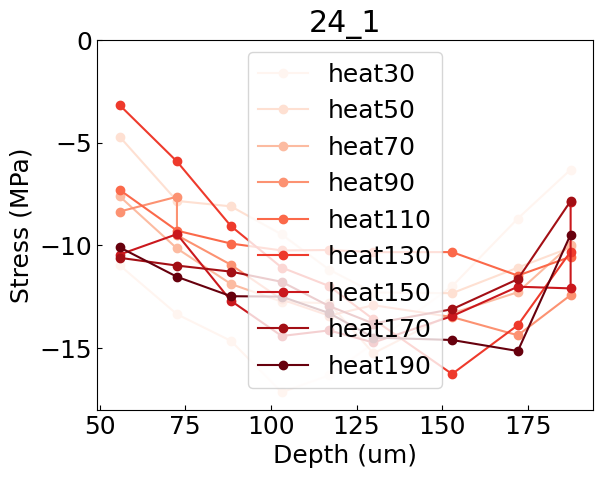

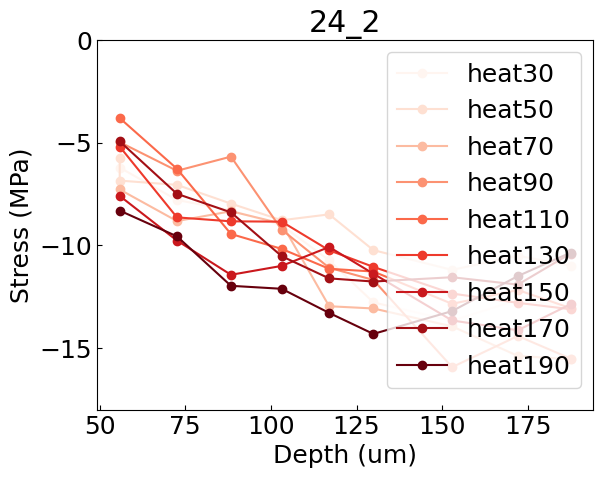

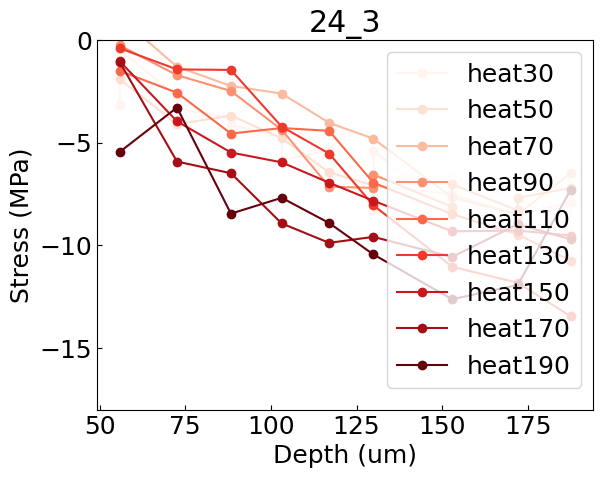

In [27]:
all = ["24_1", "24_2", "24_3"]
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 18
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
saved_datas = []
for no in all:
    paths = os.listdir(f"datas/SPring8/{no}")
    temps = [path.split("_")[-5] for path in paths]
    temps = set(temps)
    colors = plt.get_cmap('Reds')(np.linspace(0, 1, len(temps)))
    temps = sorted(temps, key=lambda x: int(x.replace('heat', '')))
    for i, temp in enumerate(temps):
        _paths = [path for path in paths if temp in path]
        _paths = [os.path.join(f"datas/SPring8/{no}", path) for path in _paths]
        datas = [SP8_data(path=path) for path in _paths]
        alphas = [data.path.split("_")[-4] for data in datas]
        rs = [data.r for data in datas]
        alphas = [float(alpha) / 100 for alpha in alphas]
        depths = [depth.depth(alpha=alpha, phi=np.mean([90, 80, 70, 60, 50, 40, 30]), twotheta=12.2) * 10000 for alpha in alphas]
        plt.plot(depths, rs, 'o-', color=colors[i], label=temp)
        if temp == 'heat30':
            for data in datas:
                saved_datas.append(data)

    plt.xlabel("Depth (um)")
    plt.ylabel("Stress (MPa)")
    plt.ylim(-18, 0)
    plt.legend()
    plt.title(no)
    plt.savefig(f"temp/{no}.svg", bbox_inches='tight')
    plt.show()

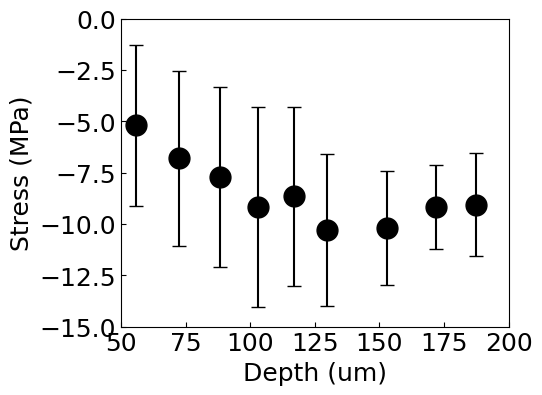

In [31]:
alpha = [data.path.split("_")[-4] for data in saved_datas]
alpha = set(alpha)
alpha = sorted(alpha, key=lambda x: int(x))
fig = plt.figure(figsize=(5, 4))
for a in alpha:
    _datas = [data for data in saved_datas if data.path.split("_")[-4] == a]
    r = np.mean([data.r for data in _datas])
    std = np.std([data.r for data in _datas])
    d = depth.depth(alpha=float(a) / 100, phi=np.mean([90, 80, 70, 60, 50, 40, 30]), twotheta=12.2) * 10000
    plt.errorbar(d, r, yerr=std, fmt='o', color='black', markersize=15, capsize=5)

plt.xlabel("Depth (um)")
plt.ylabel("Stress (MPa)")
plt.ylim(-15, 0)
plt.xlim(50, 200)
plt.xticks(np.arange(50, 201, 25))
plt.savefig(filedialog.asksaveasfile(title="Save Figure", defaultextension=".svg", filetypes=[("SVG files", "*.svg")]).name, bbox_inches='tight')


In [2]:
with open("datas/Et/20250601/results.json", "r") as f:
    data = json.load(f)

a, b = data["a"], data["b"]

In [3]:
a*25+b

3.721287958140678

  0%|          | 0/6 [00:00<?, ?it/s]

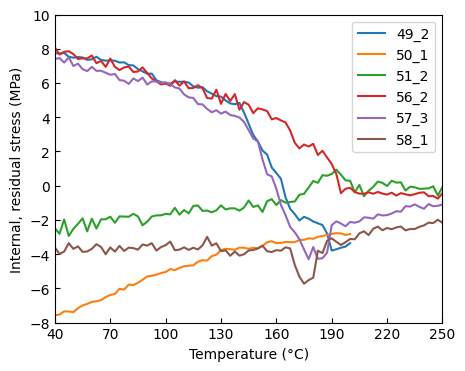

In [5]:
samples = ["49_2", "50_1", "51_2", "56_2", "57_3", "58_1"]
# samples = ["49_1", "49_2", "49_3"]
for sample in tqdm(samples):
    paths = os.listdir(f"datas/SPring8/{sample}")
    paths = [path for path in paths if 'before' not in path]
    # for path in tqdm(paths):
    #     data = SP8_data(path=os.path.join(f"datas/SPring8/{sample}", path))
    #     number = int(path.split("_")[-1])
    #     if number < 85:
    #         temp = number * 2.5 + 40
    #     else:
    #         temp = 250 - (number - 84) * 2.5
    #     modulus = a * temp + b
    #     data.modulus = modulus
    #     data.temp = temp
    #     bools = data.bools
    #     data.recalc_stress(bools, logging=lambda x: None)
    #     data.save_datas(f"datas/SPring8/{sample}", path.split(".")[0], logging=lambda x: None)
    temps = [SP8_data(path=os.path.join(f"datas/SPring8/{sample}", path)).temp for path in paths if 'before' not in path and int(path.split("_")[-1]) < 85]
    stress = [SP8_data(path=os.path.join(f"datas/SPring8/{sample}", path)).r for path in paths if 'before' not in path and int(path.split("_")[-1]) < 85]
    plt.plot(temps, stress)
plt.xlabel("Temperature (°C)")
plt.ylabel("Internal, residual stress (MPa)")
plt.xlim(40, 250)
plt.xticks(np.arange(40, 251, 30))
plt.ylim(-8, 10)
plt.yticks(np.arange(-8, 11, 2))
plt.legend(samples)
plt.savefig(filedialog.asksaveasfile(title="Save Figure", defaultextension=".svg", filetypes=[("SVG files", "*.svg")]).name, bbox_inches='tight')
plt.show()


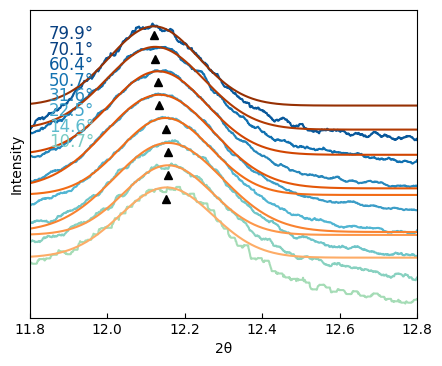

In [3]:
path = "datas/SPring8/56_2/56_2_EPPEEK_none_insitu_150_10s_1_00000"
data = SP8_data(path=path)
fig, ax = plt.subplots(figsize=(5, 4))
ax = data.plot_fitting(logging=lambda x: None, ax=ax)

psi = data.psi_SPring8
psi = [round(x, 1) for x in psi]
for i, p in enumerate(psi[::-1]):
    ax.text(0.05, 0.95 - i * 0.05, f"{p}°", transform=ax.transAxes, fontsize=12, 
            color=cm.GnBu((len(psi) + 5 - i) / (len(psi) + 4)),
            ha='left', va='top')

plt.xlim(11.8, 12.8)
plt.xticks(np.arange(11.8, 12.9, 0.2))
plt.savefig(filedialog.asksaveasfile(title="Save Figure", defaultextension=".svg", filetypes=[("SVG files", "*.svg")]).name, bbox_inches='tight')

In [5]:
data.r

8.076603437496296

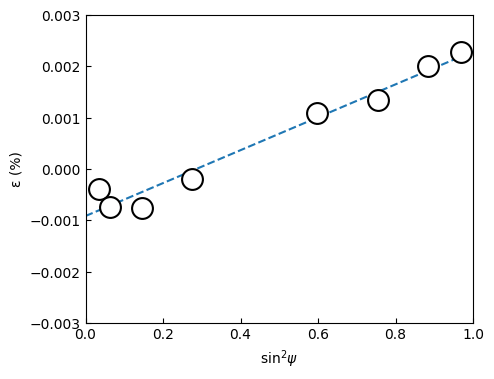

In [4]:
from SPring8 import SP8_data
from tkinter import filedialog
path = "datas/SPring8/56_2/56_2_EPPEEK_none_insitu_150_10s_1_00000"
data = SP8_data(path=path)
data.plot_e(save_path=filedialog.asksaveasfile(title="Save Figure", defaultextension=".svg", filetypes=[("SVG files", "*.svg")]).name, logging=lambda x: None)
# data.plot_e(logging=lambda x: None)